In [1]:
# %%
# Modern TCN 推荐参数
import matplotlib.pyplot as plt
from mix_data_pos_all import *
import numpy as np
from tqdm import tqdm
from typing import List
import torch
from torch import nn, Tensor
import torch.utils.data as Data

# %matplotlib widget
from typing import List
import datetime
now = datetime.datetime.now().strftime('%b%d_%H-%M')

from matplotlib import font_manager
source_han_sans_path = '/home/huxianan/.local/share/fonts/adobe-source-han-sans/SourceHanSansCN-Normal.otf'
my_font = font_manager.FontProperties(fname=source_han_sans_path)
font_manager.fontManager.addfont(source_han_sans_path)
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False

In [2]:
use_cuda = True
device = torch.device(f"cuda:0" if (
    use_cuda and torch.cuda.is_available()) else "cpu")
# device = torch.device("cpu")
print("CUDA Available: ", torch.cuda.is_available(), 'use:', device)

CUDA Available:  True use: cuda:0


In [3]:
from my_datastes import MyDataSet, MyDataSet_woEmb

from my_tools import *
TAG_LEN = 12
BATCH_SIZE = 256 * 2
# INPUT_CHANNELS = 5
# POS_D = D = 128
# P = 1
# S = 1
# R = 2
# NUM_LAYERS = 24
# DROP_OUT = 0.5 # dropout 仅指分类头的。不能在主干。ref. https://arxiv.org/abs/1801.05134v1
# HARD_RATIO = 80

# TCN: modern TCN
# Linear 线性（模）值域宽尺度特征提取
# mask（mean 掩码）掩码难样本处理 randMask 随机掩码
# D L R: TCN 参数
# MT: 混入测试集 mix test
# Easy: 2,2,1,2
# H: hard


seed_everything()

# 训练数据准备


def make_data(d: List[List[np.ndarray]]):
    """生成数据集
    Args:
        d 数据集
    Returns:
        inputs2 = 特征
        targets = [[TAG] * 时间窗长度] * 样本数 one-hot 编码
    """
    inputs = np.array([i[0] for i in d], dtype=np.float32)
    targets = np.array([i[-1] for i in d], dtype=np.int64) - 1

    # 对 'TAG' 列的值 1~12 进行 one-hot 编码
    # targets = np.eye(12)[targets - 1] #(原标签 -1) 作为索引，生成对应的单位矩阵

    return torch.FloatTensor(inputs), torch.LongTensor(targets)


df_list, test_df_list = read_dfs()

# %%
# 释放显卡内存
torch.cuda.empty_cache()
# %%


def criterion(outputs: torch.FloatTensor, targets: torch.FloatTensor):
    """自定义 loss function
    loss_1 : 模型最终输出的交叉熵损失
    """

    # loss_1 = focal_loss(outputs.view(-1, 12), targets.view(-1), alpha=None, reduction='mean')
    loss_1 = nn.CrossEntropyLoss()(outputs.view(-1, 12), targets.view(-1))
    return loss_1

set all seed: 3407
并行读取数据集中... 读取数据集 end


In [4]:
# 噪声抵抗测试

pths = []

pths.append('./saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hrr1R_MT_May08_12-51_mloss.pth') # 宽值域嵌入+随机掩码
pths.append('./saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hrc1R_MT_May09_08-48_mloss.pth') # 宽值域嵌入+常数掩码
pths.append('./saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hr1R_MT_May07_08-56_mloss.pth') # 宽值域嵌入+均值掩码
pths.append('./saved_models/TCN_51KS5_128D24L2R5dp_PosAll0Hr1R_MT_May07_12-08_mloss.pth') # 宽值域嵌入+无掩码
pths.append('./saved_models/TCN_51KS5_128D24L2R5dp_PosAll80Hr1R_MT_LEmb_May06_14-01_mloss.pth') # 自学习嵌入+无掩码

names = ['宽值域嵌入+随机掩码', '宽值域嵌入+常数掩码', '宽值域嵌入+均值掩码', '宽值域嵌入+无掩码', '自学习嵌入+无掩码']

In [5]:


ratios = np.linspace(1, 10, 10)
accs = np.zeros((len(pths), len(ratios)))


for i_n, NAME in enumerate(pths):

    checkpoint = torch.load(f'{NAME}', map_location=torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu'))

    model = checkpoint['model']
    model.structural_reparam()
    # # ! 需要 2.0+ torch
    # model = torch.compile(model)
    # torch.set_float32_matmul_precision('high')

    model.to(device)
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(len(ratios))):
            test_windows = []
            df = test_df_list[2]
            for _ in range(BATCH_SIZE):
                start = random.randint(0, len(df) - WINDOW_SIZE)
                m2, m3 = to_dict(df[start:start + WINDOW_SIZE],
                                 reshap=True, noise=ratios[i])
                test_windows.append([m2, m3])
            d_test = test_windows

            if i_n == len(pths) - 1:
                l = Data.DataLoader(MyDataSet_woEmb(
                    *make_data(d_test)), batch_size=BATCH_SIZE, shuffle=True)
            else:
                l = Data.DataLoader(
                    MyDataSet(*make_data(d_test)), batch_size=BATCH_SIZE, shuffle=True)

            loss = 0
            predictions = np.array([]).astype(int)
            targets = np.array([]).astype(int)
            for data, target in l:
                data = data.to(device)
                target = target.to(device)
                output = model(data)

                # 计算预测值
                predictions = np.append(predictions, torch.argmax(
                    output.view(-1, 12), -1).cpu().numpy())

                targets = np.append(targets, target.view(-1).cpu().numpy())

                loss += criterion(output, target).item()

            loss /= len(l)
            accs[i_n, i] = accuracy_score(targets, predictions)
            
    del model
    del checkpoint
    torch.cuda.empty_cache()
    
print(repr(accs))
print(repr(ratios))
print(repr(names))


100%|██████████| 10/10 [02:49<00:00, 16.94s/it]

array([[0.96572685, 0.83175659, 0.72347069, 0.65086555, 0.58961678,
        0.55411148, 0.5343132 , 0.52498055, 0.51091003, 0.50781822],
       [0.96403694, 0.83969307, 0.60655785, 0.42778015, 0.30978203,
        0.25240326, 0.21086502, 0.19015694, 0.16661453, 0.14870453],
       [0.96415901, 0.65245819, 0.46385193, 0.2978344 , 0.20386124,
        0.15946198, 0.13738632, 0.13305473, 0.12346268, 0.11844635],
       [0.96793175, 0.56253815, 0.32622147, 0.20367241, 0.16745186,
        0.12507248, 0.10462761, 0.09079552, 0.07631111, 0.07673264],
       [0.95453262, 0.72758293, 0.49789047, 0.28264618, 0.16472244,
        0.14170456, 0.12224579, 0.10971642, 0.10486984, 0.10378647]])
array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
['宽值域嵌入+随机掩码', '宽值域嵌入+常数掩码', '宽值域嵌入+均值掩码', '宽值域嵌入+无掩码', '自学习嵌入+无掩码']


```python
array([[0.96572685, 0.83175659, 0.72347069, 0.65086555, 0.58961678,
        0.55411148, 0.5343132 , 0.52498055, 0.51091003, 0.50781822],
       [0.96403694, 0.83969307, 0.60655785, 0.42778015, 0.30978203,
        0.25240326, 0.21086502, 0.19015694, 0.16661453, 0.14870453],
       [0.96415901, 0.65245819, 0.46385193, 0.2978344 , 0.20386124,
        0.15946198, 0.13738632, 0.13305473, 0.12346268, 0.11844635],
       [0.96793175, 0.56253815, 0.32622147, 0.20367241, 0.16745186,
        0.12507248, 0.10462761, 0.09079552, 0.07631111, 0.07673264],
       [0.95453262, 0.72758293, 0.49789047, 0.28264618, 0.16472244,
        0.14170456, 0.12224579, 0.10971642, 0.10486984, 0.10378647]])
array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
['宽值域嵌入+随机掩码', '宽值域嵌入+常数掩码', '宽值域嵌入+均值掩码', '宽值域嵌入+无掩码', '自学习嵌入+无掩码']
```

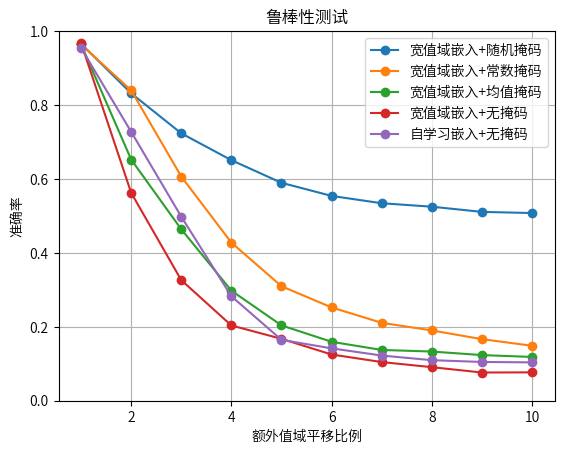

In [6]:
plt.figure()
for i in range(len(pths)):
    plt.plot(ratios, accs[i, :], label=names[i],
             linestyle="-", marker="o")
plt.grid()
plt.ylim(0, 1)
plt.legend()
# plt.xscale("log")
plt.xlabel('额外值域平移比例')
plt.ylabel('准确率')
plt.title(f'鲁棒性测试')
# plt.savefig(f'tmp.svg')
plt.show()

In [7]:
# 噪声抵抗测试 snr

# SNR db
ratios = np.array([-30, -20, -15, -10, -5, 0, 5, 10])
accs = np.zeros((len(pths), len(ratios)))


for i_n, NAME in enumerate(pths):

    checkpoint = torch.load(f'{NAME}', map_location=torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu'))

    model = checkpoint['model']
    model.structural_reparam()
    # # ! 需要 2.0+ torch
    # model = torch.compile(model)
    # torch.set_float32_matmul_precision('high')

    model.to(device)
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(len(ratios))):
            test_windows = []
            df = test_df_list[2]
            for _ in range(BATCH_SIZE):
                start = random.randint(0, len(df) - WINDOW_SIZE)
                m2, m3 = to_dict(df[start:start + WINDOW_SIZE],
                                 reshap=True, noise_snr=ratios[i])
                test_windows.append([m2, m3])
            d_test = test_windows

            if i_n == len(pths) - 1:
                l = Data.DataLoader(MyDataSet_woEmb(
                    *make_data(d_test)), batch_size=BATCH_SIZE, shuffle=True)
            else:
                l = Data.DataLoader(
                    MyDataSet(*make_data(d_test)), batch_size=BATCH_SIZE, shuffle=True)

            loss = 0
            predictions = np.array([]).astype(int)
            targets = np.array([]).astype(int)
            for data, target in l:
                data = data.to(device)
                target = target.to(device)
                output = model(data)

                # 计算预测值
                predictions = np.append(predictions, torch.argmax(
                    output.view(-1, 12), -1).cpu().numpy())

                targets = np.append(targets, target.view(-1).cpu().numpy())

                loss += criterion(output, target).item()

            loss /= len(l)
            accs[i_n, i] = accuracy_score(targets, predictions)
            
    del model
    del checkpoint
    torch.cuda.empty_cache()

print(repr(accs))
print(repr(ratios))
print(repr(names))


100%|██████████| 8/8 [04:29<00:00, 33.69s/it]

array([[0.14503098, 0.26545906, 0.40004349, 0.58311462, 0.75305939,
        0.88718605, 0.94384956, 0.95778084],
       [0.13772392, 0.179533  , 0.25424767, 0.40323257, 0.6621151 ,
        0.85041428, 0.93197441, 0.95745087],
       [0.09838676, 0.17437553, 0.24561691, 0.41224289, 0.67376137,
        0.86532784, 0.93507576, 0.95401192],
       [0.05282784, 0.17405319, 0.2345314 , 0.36227036, 0.59780502,
        0.80922699, 0.92213631, 0.95691109],
       [0.1066246 , 0.10880661, 0.10791397, 0.15756035, 0.5440464 ,
        0.85450363, 0.9260006 , 0.94773865]])
array([-30, -20, -15, -10,  -5,   0,   5,  10])
['宽值域嵌入+随机掩码', '宽值域嵌入+常数掩码', '宽值域嵌入+均值掩码', '宽值域嵌入+无掩码', '自学习嵌入+无掩码']


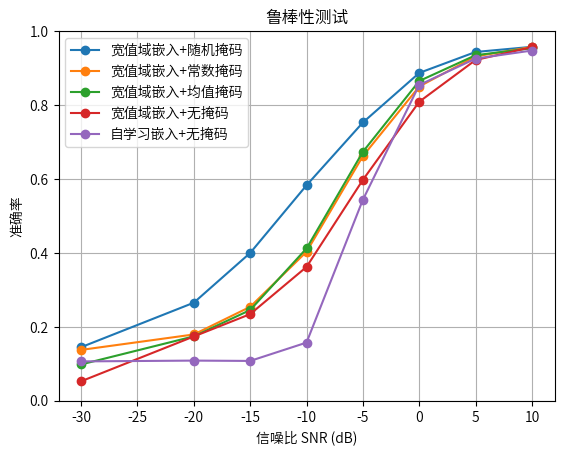

In [8]:
plt.figure()
for i in range(len(pths)):
    plt.plot(ratios, accs[i, :], label=names[i],
             linestyle="-", marker="o")
plt.grid()
plt.ylim(0, 1)
plt.legend()
# plt.xscale("log")
plt.xlabel('信噪比 SNR (dB)')
plt.ylabel('准确率')
plt.title('鲁棒性测试')
# plt.savefig(f'tmp.svg')
plt.show()

In [ ]:

plt.figure()
acc = [0.9649772644042969, 0.831451416015625,
        0.7574539184570312, 0.6687850952148438, 0.6081390380859375]
plt.plot(ratios, acc, label="宽值域嵌入+随机掩码（本专利建议方案）", linestyle="-", marker="o")
acc = [0.9507560729980469, 0.8138046264648438,
        0.5247421264648438, 0.3176422119140625, 0.21827316284179688]
plt.plot(ratios, acc, label="宽值域嵌入+均值掩码", linestyle="-", marker=".")
acc = [0.9687709808349609, 0.6324844360351562,
        0.3233928680419922, 0.18905067443847656, 0.1345062255859375]
plt.plot(ratios, acc, label="宽值域嵌入+无掩码", linestyle="-", marker="+")
acc = [0.9516983032226562, 0.7362327575683594,
        0.5110855102539062, 0.2882881164550781, 0.16313934326171875]
plt.plot(ratios, acc, label="自学习嵌入+无掩码", linestyle="-", marker="x")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.xscale("log")

plt.xlabel('额外平移比例')
plt.ylabel('准确率')
plt.title(f'鲁棒性测试')
# plt.savefig(f'tmp.svg')
plt.show()